In [57]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [58]:
# Loading and splitting the data
train_data = pd.read_csv('datasets/train.csv')

X = train_data.drop(columns=['A', 'B', 'C', 'D', 'E', 'Y'])  # Features (wavelengths 3800-7377)
y = train_data[['A', 'B', 'C', 'D', 'E', 'Y']]  # Targets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Preprocessing 
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_train_tensor = {target: torch.tensor(y_train[target].values, dtype=torch.float32).to(device) for target in ['A', 'B', 'C', 'D', 'E', 'Y']}
y_val_tensor = {target: torch.tensor(y_val[target].values, dtype=torch.float32).to(device) for target in ['A', 'B', 'C', 'D', 'E', 'Y']}

In [61]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim=6):  # Add output_dim for multi-output
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)  # Predict multiple outputs
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [62]:
models = {}
predictions = {}
EPOCH = 100

Training model for A...
MAPE for A: 0.24%


c:\Users\ConanKudo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


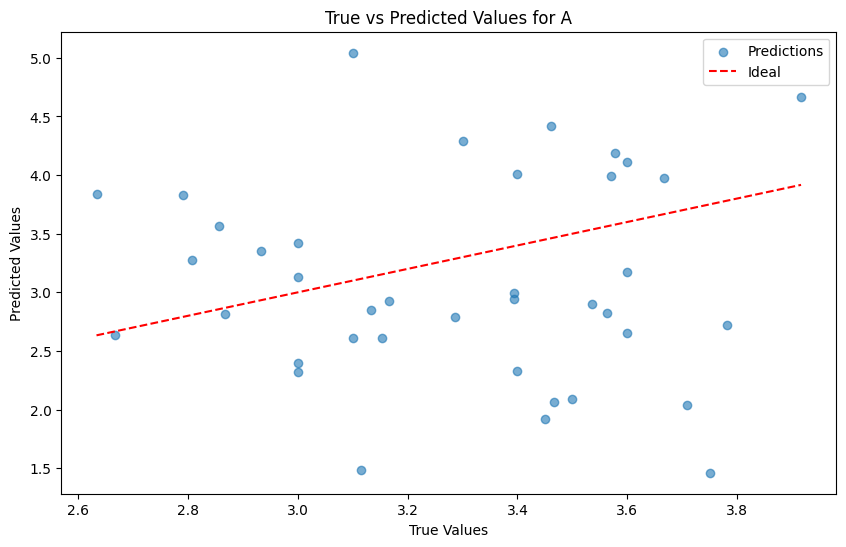

Training model for B...
MAPE for B: 0.24%


c:\Users\ConanKudo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


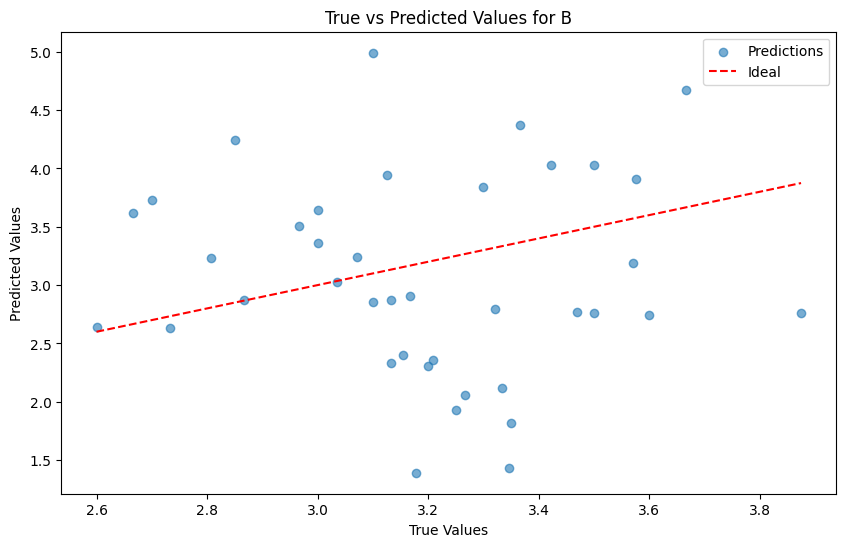

Training model for C...
MAPE for C: 0.26%


c:\Users\ConanKudo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


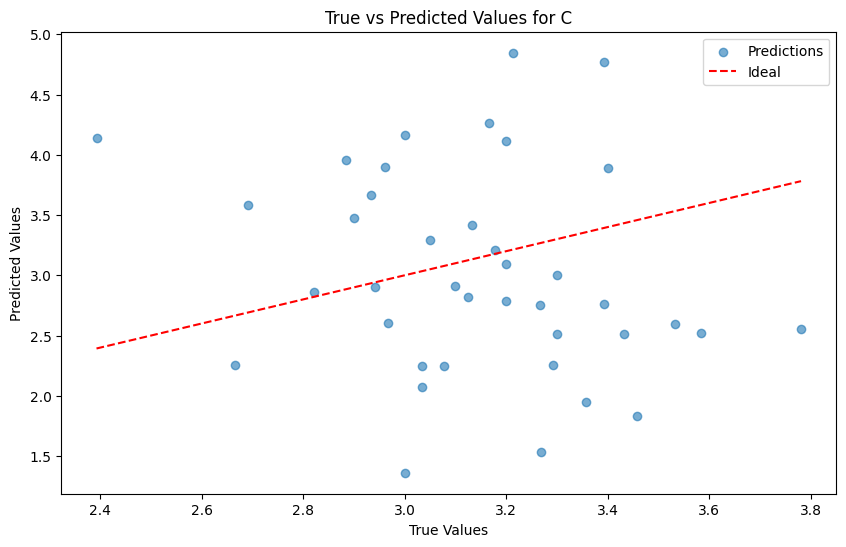

Training model for D...
MAPE for D: 0.21%


c:\Users\ConanKudo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


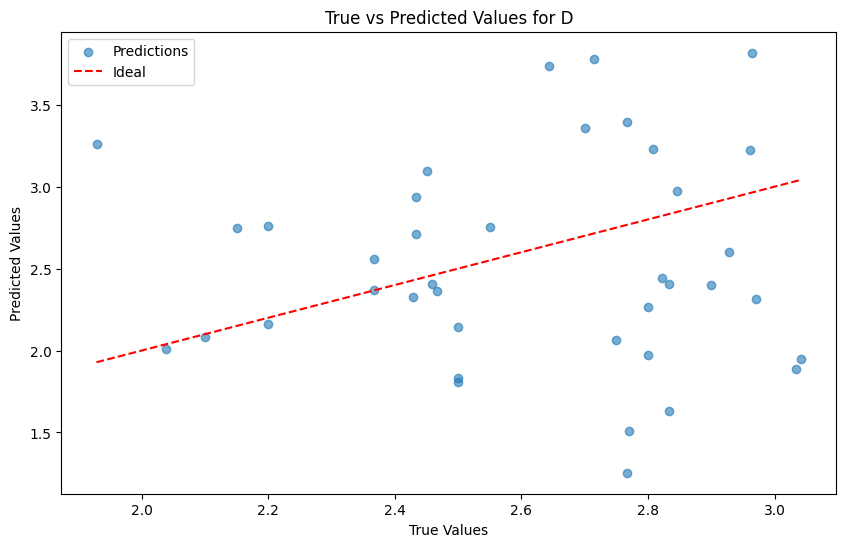

Training model for E...
MAPE for E: 0.22%


c:\Users\ConanKudo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


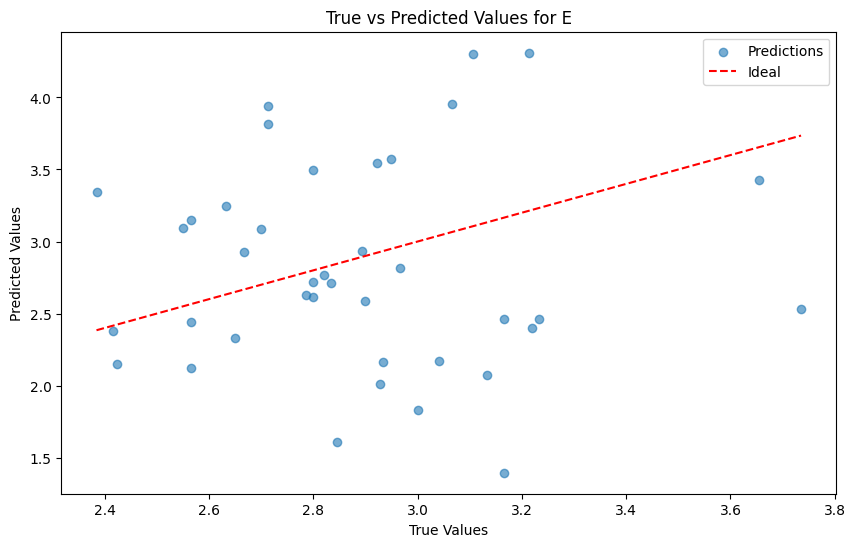

Training model for Y...
MAPE for Y: 0.40%


c:\Users\ConanKudo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


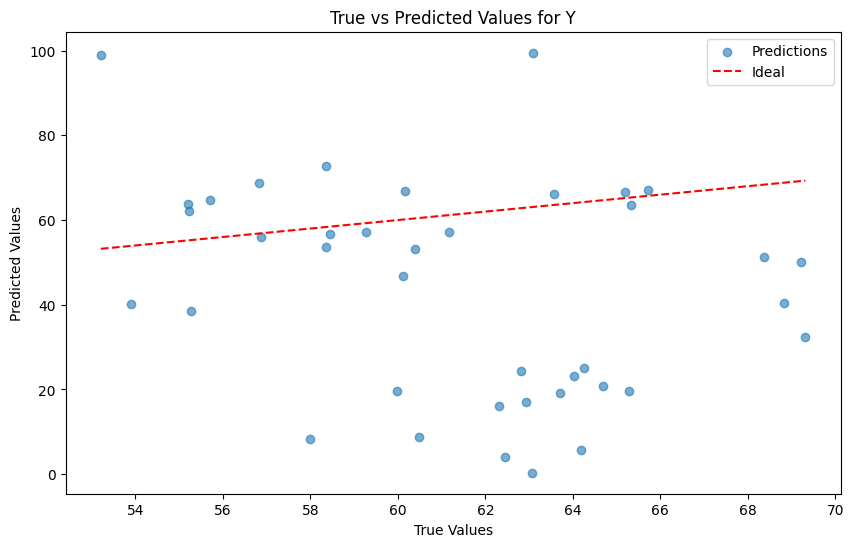

In [63]:
for target in ['A', 'B', 'C', 'D', 'E', 'Y']:
    print(f"Training model for {target}...")
    
    model = SimpleNN(X_train_tensor.shape[1], output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(EPOCH):  # Number of epochs
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor[target].unsqueeze(1))
        loss.backward()
        optimizer.step()
    
    models[target] = model
    
    # Predicting on the validation set
    model.eval()
    with torch.no_grad():
        pred = model(X_val_tensor).squeeze().cpu().numpy()
    predictions[target] = pred
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val[target].values, pred)  # Convert y_val[target] to NumPy array
    print(f"MAPE for {target}: {mape:.2f}%")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val[target].values, pred, alpha=0.6, label='Predictions')  # Convert y_val[target] to NumPy array cause yes
    plt.plot([y_val[target].min(), y_val[target].max()], [y_val[target].min(), y_val[target].max()], 'r--', label='Ideal')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted Values for {target}')
    plt.legend()
    plt.show()

In [64]:
prediction_df = pd.DataFrame(predictions)
print(prediction_df)

           A         B         C         D         E          Y
0   2.991206  2.793637  2.788260  2.407725  2.613520  17.068756
1   5.043834  4.992547  4.770068  3.777959  4.298646   4.140299
2   3.176630  2.872689  2.904265  2.312770  2.530202  66.996590
3   3.974615  3.946774  3.957470  3.221587  3.428293  63.582943
4   2.068754  2.054689  2.070917  1.833727  2.121966   8.768165
5   2.655295  2.747568  2.556242  2.067274  2.400259  32.379101
6   2.606513  2.630482  2.607838  2.161277  2.439847  38.573578
7   2.940316  3.238495  2.858437  2.439584  2.765657  19.678617
8   2.718462  2.771377  2.598740  2.400638  2.461343  51.228191
9   3.562433  3.645456  3.472843  2.749740  3.093210  63.718006
10  1.461434  1.391311  1.362175  1.254374  1.395834  23.124763
11  3.839935  3.732352  3.667049  2.935764  3.245966  40.068516
12  2.036662  1.929386  1.950534  1.808594  2.011525  25.142159
13  3.991140  4.033504  3.889494  3.093683  3.573331  66.632118
14  4.287605  4.368866  4.264001  3.3969